In [1]:
#!pip install qiskit-machine-learning 

import qiskit

In [2]:
import pandas as pd
import numpy as np

def convert(df):
    df['phenomenon time'] = pd.to_datetime(df['phenomenon time'])
    df['result'] = pd.to_numeric(df['result'])
    df['date'] = df['phenomenon time'].dt.date
    df['class'] = pd.cut(df['result'], bins=[0, 9, 100], labels=[0,1])

    # Calculate the maximum values of the 'data' column for each group
    result = df.groupby('date')['result'].max().reset_index()
    classes = pd.cut(result['result'], bins=[0, 9, 100], labels=[0,1])
    return result, classes

def load(file):
    return pd.read_csv('./Data/River_Data/'+file)# , nrows=10)  

def merge(old, df, index):
    df = df.rename(columns={'result': 'result'+str(index)})
    allresults = pd.merge(old, df, on='date')
    return allresults

def shift_prediction_days(df, days):
    columns = len(df.columns) - 2
    for index, row in df.iterrows():
        if index < df.shape[0]-1:
            for i in range(columns):
                key = "result" + str(i+1)
                row[key] = df.iloc[index+days][key]
            df.iloc[index] = row

    df = df.drop(df.index[-days:])
    return df

In [3]:
data3 = pd.read_csv('./Data/river-meta-data.csv',sep=";")
display(data3.head())

main_station = '2024_02_23__SKLU__WST__2024-02-27.csv'

allresults, classes = convert(load(main_station))
feature_names = np.array(['water-level [cm] Kluserbrücke'])
data_keys = np.array([])
data_keys = np.append(data_keys, "result")

data_index = 1
for index, row in data3.iterrows():
    #print(row['File-name'])
        file = row['File-name'].replace('.CSV', '.csv')
        if file != main_station and row['Phenomenon'] == 'water-level [cm]':
            feature_names = np.append(feature_names, row['Phenomenon'] +" " + row['Station'])
            #print(row['Phenomenon'] +" " + row['Station'])
            result, classes = convert(load(file))
            allresults = merge(allresults, result, data_index)
            data_keys = np.append(data_keys, "result"+str(data_index))
            data_index += 1

for index, row in data3.iterrows():
    #print(row['File-name'])
    if  index < 10: # Max 11
        file = row['File-name'].replace('.CSV', '.csv')
        if file != main_station and row['Phenomenon'] != 'water-level [cm]':
            feature_names = np.append(feature_names, row['Phenomenon'] +" " + row['Station'])
            #print(row['Phenomenon'] +" " + row['Station'])
            result, classes = convert(load(file))
            allresults = merge(allresults, result, data_index)
            data_keys = np.append(data_keys, "result"+str(data_index))
            data_index += 1

allresults = allresults.dropna()
display(allresults.head())

allresults = shift_prediction_days(allresults, 1)

Station   Latitude  Longitude     ID         Phenomenon  \
0     Beyenburg (Ablaufpegel)  51.250317   7.294208   SBEY   water-level [cm]   
1     Beyenburg (Ablaufpegel)  51.250317   7.294208   SBEY   discharge [m3/s]   
2  Herbringhauser Talsperre H  51.221640   7.271520  SHT$        volume [hm3]   
3  Herbringhauser Talsperre H  51.221640   7.271520  SHT$   fill-level [müNN]   
4                Kluserbrücke  51.255604   7.158556   SKLU   water-level [cm]   

        Start         End                              File-name  
0  09.01.2012  23.02.2024  2024_02_23__SBEY__ABF__2024-02-27.CSV  
1  01.01.2007  23.02.2024  2024_02_23__SBEY__WST__2024-02-27.CSV  
2  01.11.2006  26.02.2024  2024_02_26__SHT$__SPI__2024-02-27.CSV  
3  01.11.2014  26.02.2024  2024_02_26__SHT$__SPF__2024-02-27.CSV  
4  27.10.1934  23.02.2024  2024_02_23__SKLU__WST__2024-02-27.CSV

date  result  result1  result2  result3  result4  result5  result6  \
0  2017-12-31    97.0   25.015    145.0    163.1     20.2    109.0    2.818   
1  2018-01-01   111.0   34.165    170.0    179.5     16.7    129.2    2.823   
2  2018-01-03   162.8   44.220    186.0    200.7     40.1    149.1    2.838   
3  2018-01-04   146.2   61.060    210.0    213.4     17.3    178.7    2.838   
4  2018-01-05   136.7   51.904    206.0    206.2     14.3    162.2    2.858   

   result7  result8  result9  result10  
0   271.35   34.199   19.025    21.792  
1   271.44   41.499   30.745    28.728  
2   271.44   74.850   37.326    40.301  
3   271.51   62.640   48.758    47.375  
4   271.40   56.292   47.413    44.433

In [4]:
display(allresults.head())
for name in feature_names:
    print(name)
allresults.to_csv('final_data.csv')
classes.to_csv('final_classes.csv')


date  result  result1  result2  result3  result4  result5  result6  \
0  2017-12-31    97.0   34.165    170.0    179.5     16.7    129.2    2.823   
1  2018-01-01   111.0   44.220    186.0    200.7     40.1    149.1    2.838   
2  2018-01-03   162.8   61.060    210.0    213.4     17.3    178.7    2.838   
3  2018-01-04   146.2   51.904    206.0    206.2     14.3    162.2    2.858   
4  2018-01-05   136.7   47.616    201.0    199.3     12.1    154.2    2.826   

   result7  result8  result9  result10  
0   271.44   41.499   30.745    28.728  
1   271.44   74.850   37.326    40.301  
2   271.51   62.640   48.758    47.375  
3   271.40   56.292   47.413    44.433  
4   271.33   49.679   45.155    38.966

water-level [cm] Kluserbrücke
water-level [cm] Beyenburg (Ablaufpegel)
water-level [cm] Krebsöge
water-level [cm] Laaken
water-level [cm] Leimbach
discharge [m3/s] Beyenburg (Ablaufpegel)
volume [hm3] Herbringhauser Talsperre H
fill-level [müNN] Herbringhauser Talsperre H
discharge [m3/s] Kluserbrücke
discharge [m3/s] Krebsöge
discharge [m3/s] Laaken


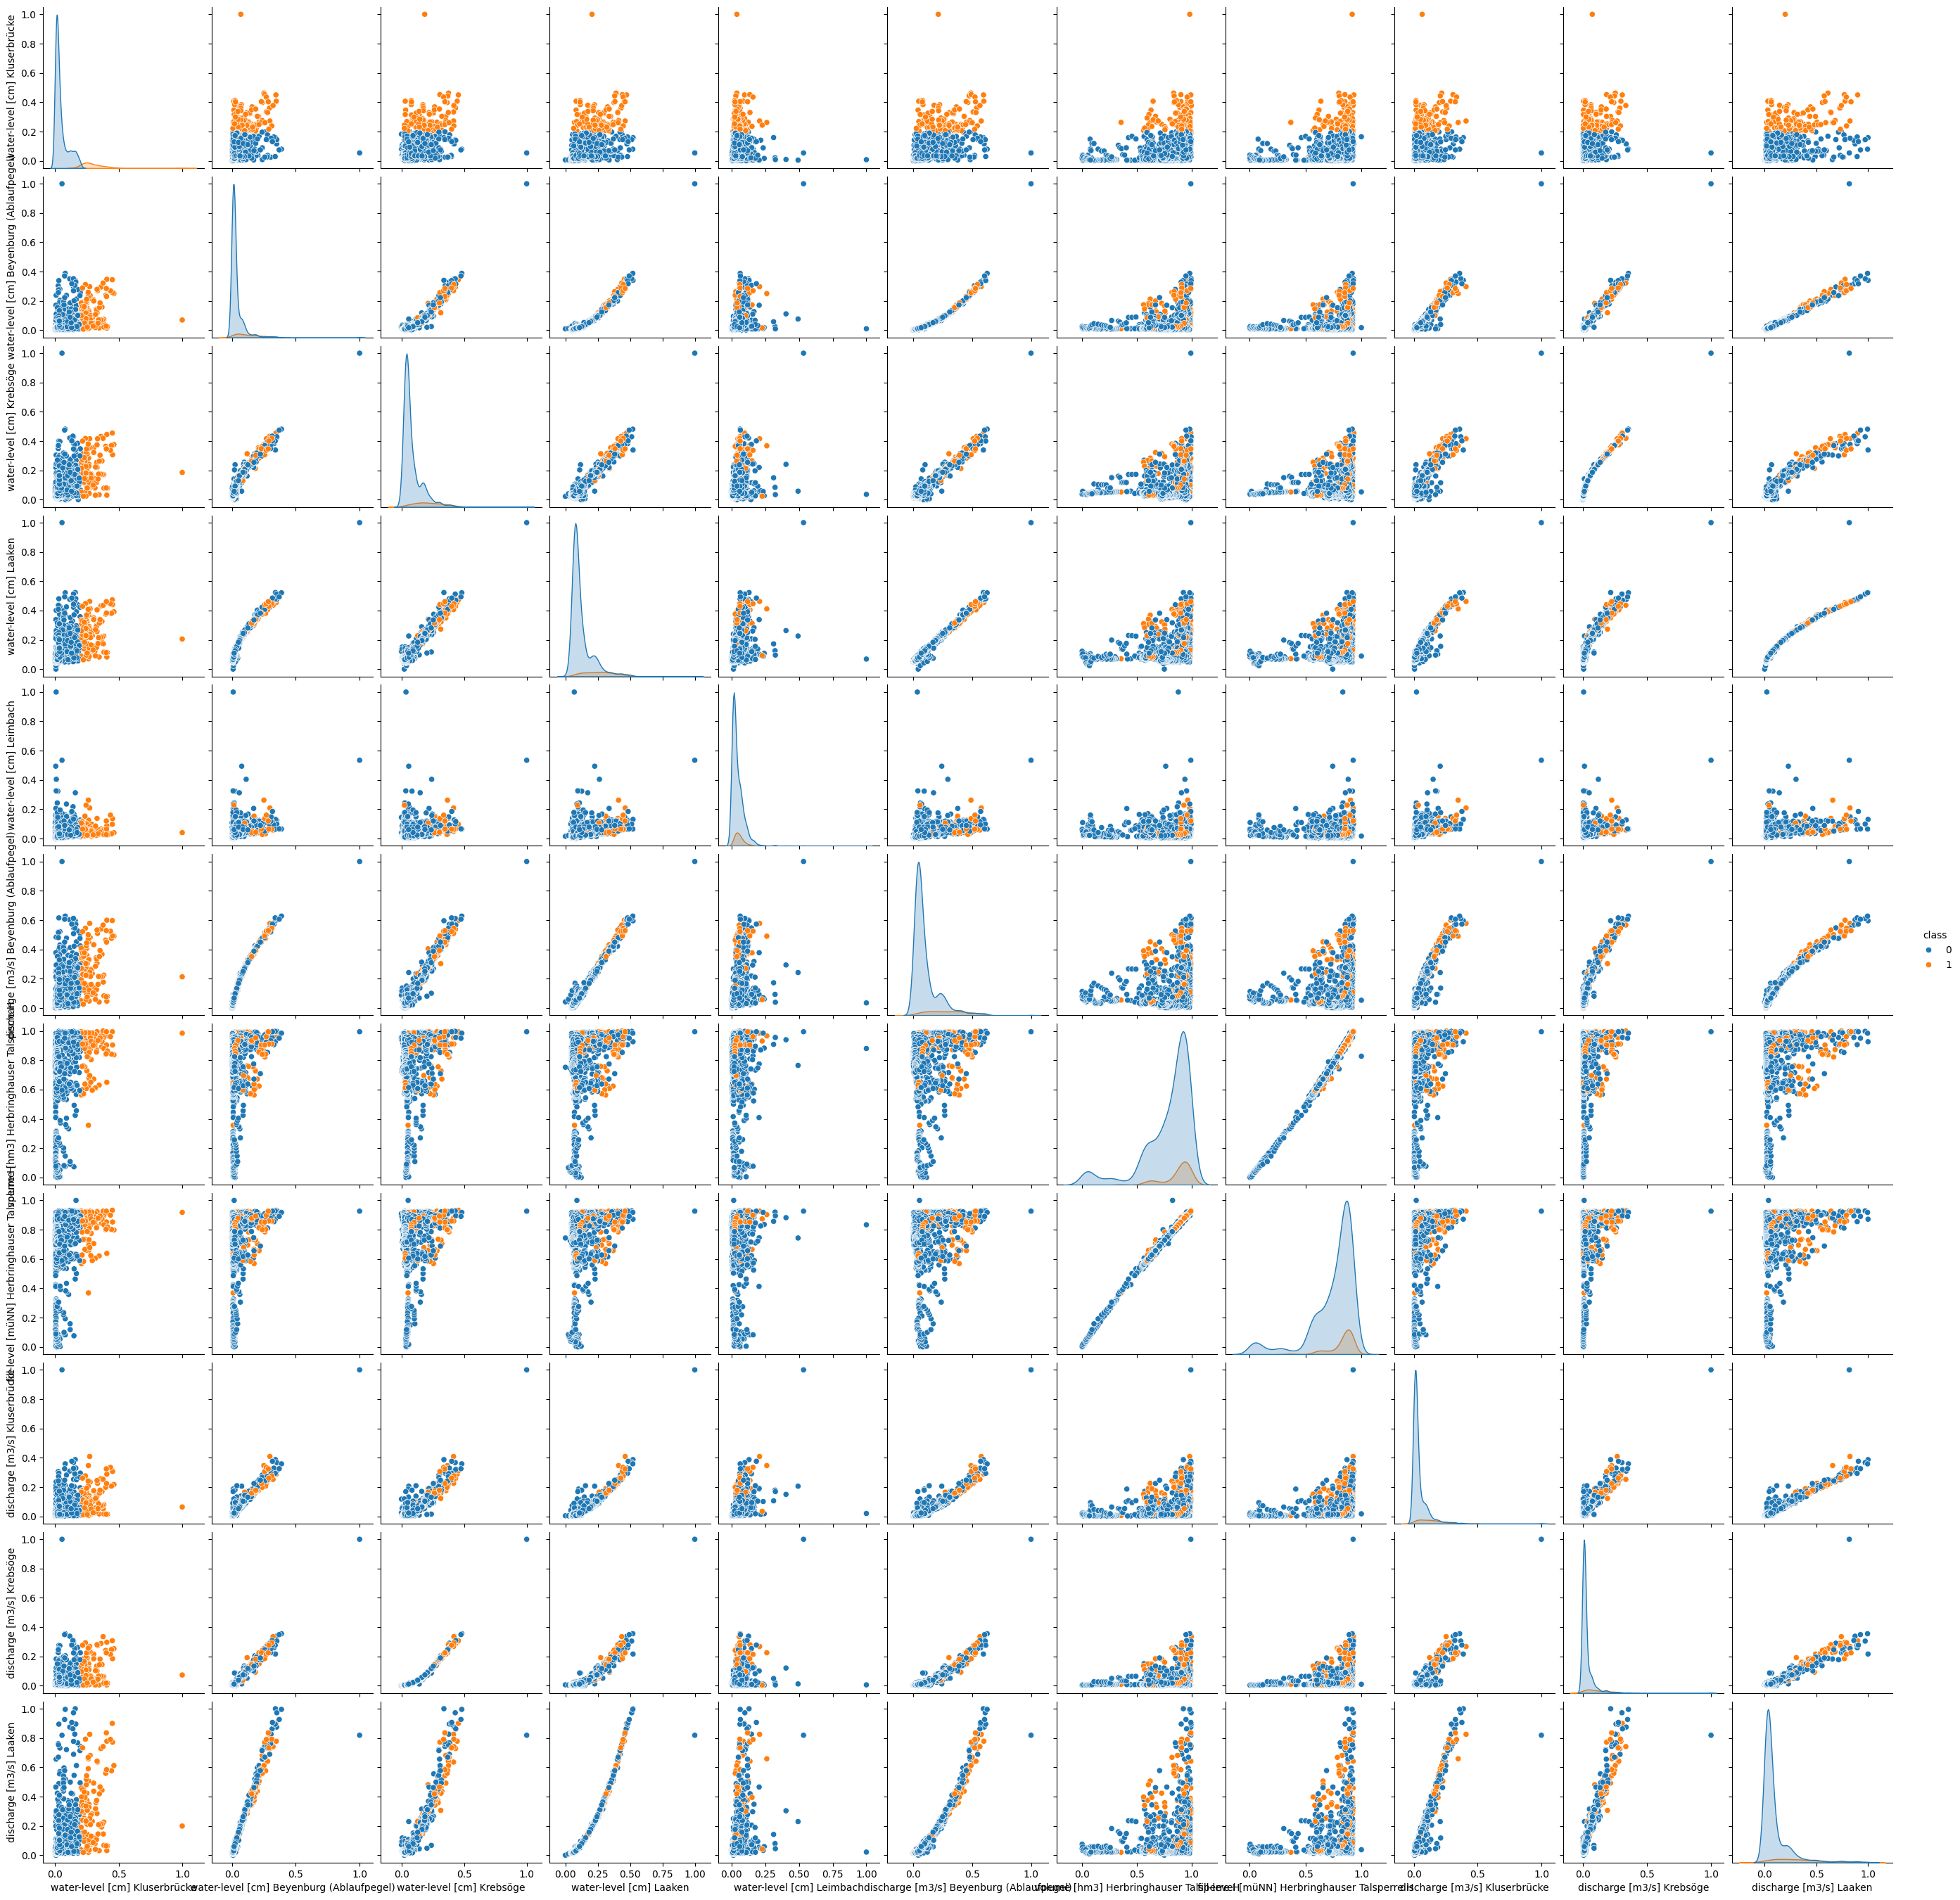

In [5]:
allresults = allresults.dropna()

classes = pd.cut(allresults['result'], bins=[-1000, 90, 1000], labels=[0,1])
features = allresults[data_keys]
labels = classes.tolist()
#print(labels)
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)


import pandas as pd
import seaborn as sns

df = pd.DataFrame(features, columns=feature_names)
df["class"] = pd.Series(labels)

sns.pairplot(df, hue="class", palette="tab10")



In [6]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8
)

In [7]:
from sklearn.svm import SVC
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.98
Classical SVC on the test dataset:     0.96


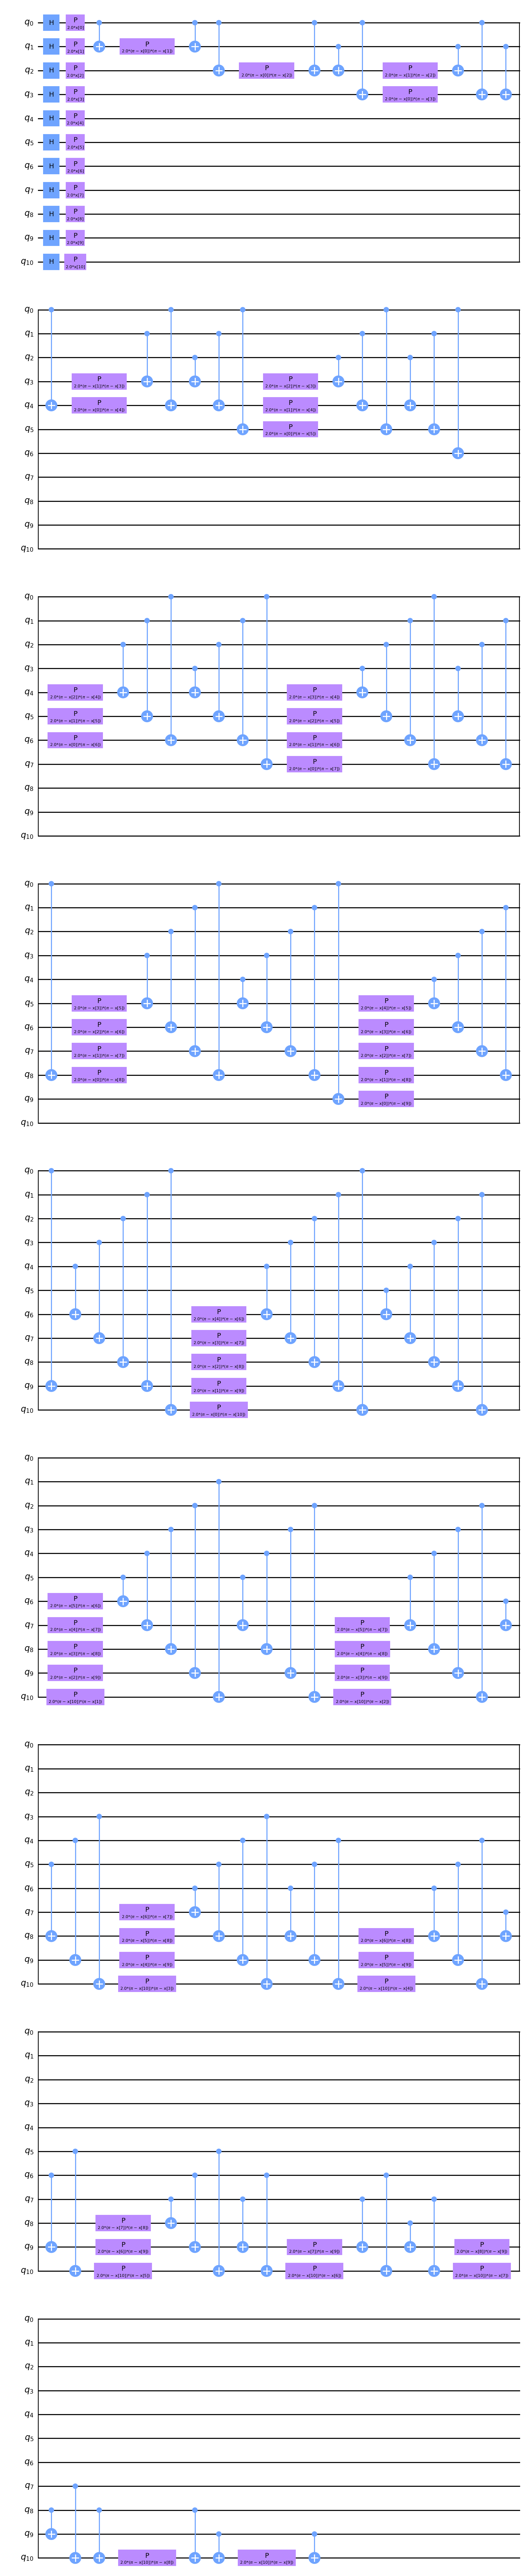

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

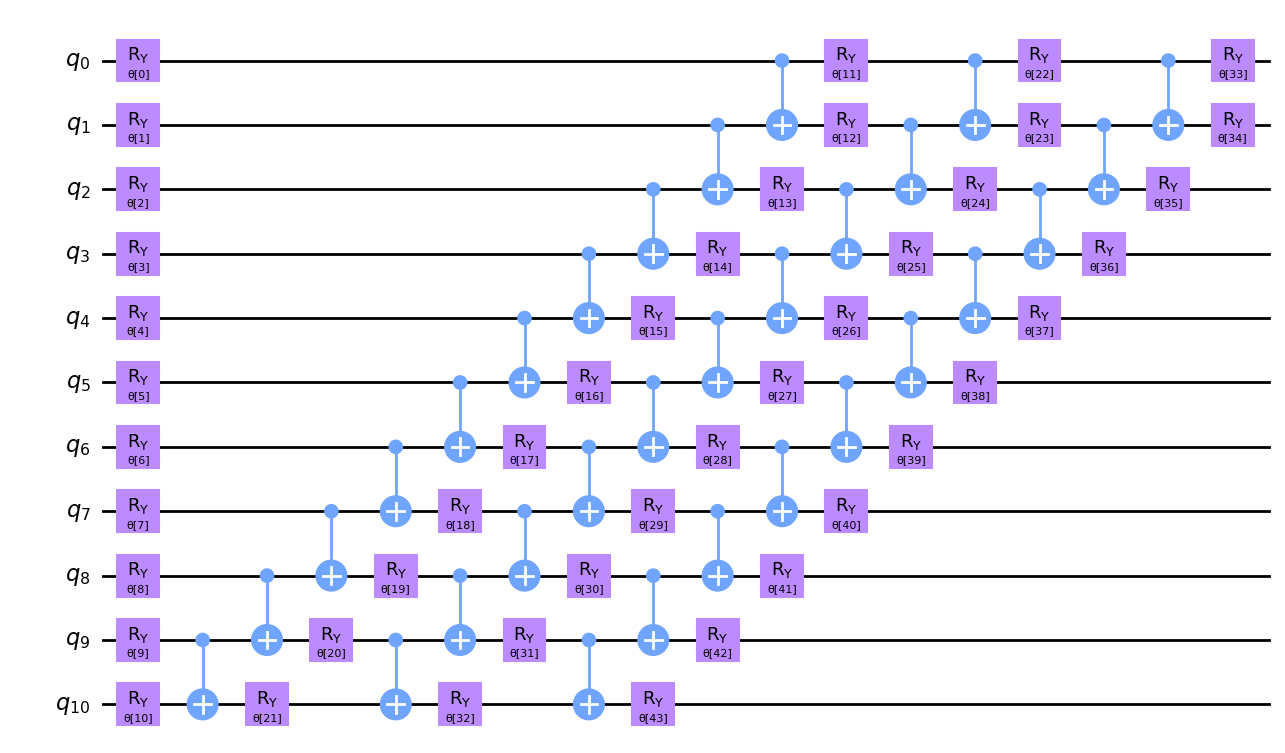

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [11]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)

/tmp/ipykernel_2246539/74709828.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [12]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

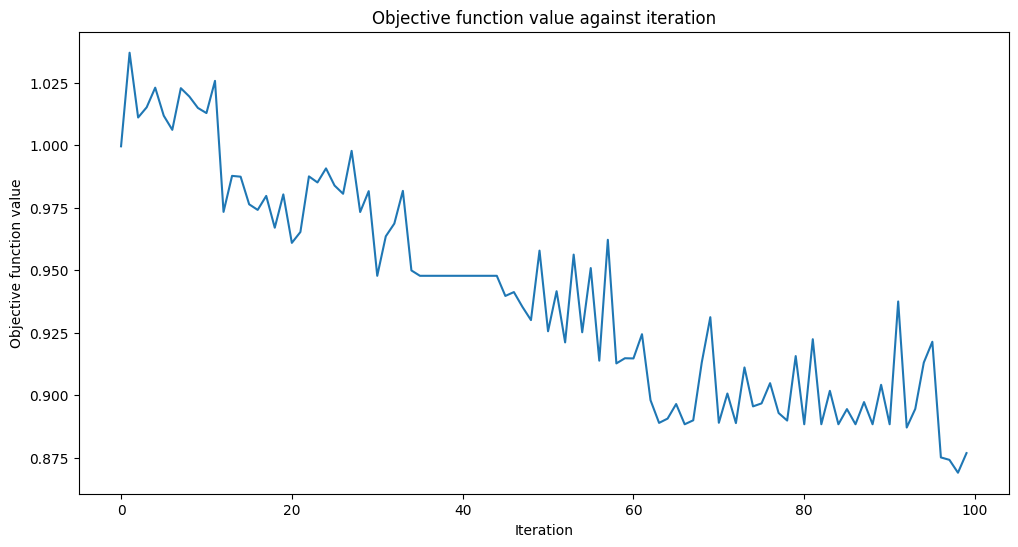

Training time: 3126 seconds


In [14]:

import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(np.array(train_features), np.array(train_labels))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [15]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.90
Quantum VQC on the test dataset:     0.89


In [18]:
print("Labels for the values to predict:")
for i, name in enumerate(feature_names):
    print(i+1, ":", name)

def is_flood(values):
    result = vqc.predict(values)
    if result == 1:
        print("There is a flood based on the current predictment model.")
        print("Based on observation values: ", values)
    else:
        print("There is no flood based on the current predictment model.")
        print("Based on observation values: ", values)
        
values = [0.9,0.5,0.9,0.5,0.9,0.4,0.9,0.4,0.9,0.2,0.9]
is_flood(values)

values = [0.1,0.3,0.3,0.2,0.1,0.3,0.3,0.2,0.1,0.3,0.3]
is_flood(values)


Labels for the values to predict:
1 : water-level [cm] Kluserbrücke
2 : water-level [cm] Beyenburg (Ablaufpegel)
3 : water-level [cm] Krebsöge
4 : water-level [cm] Laaken
5 : water-level [cm] Leimbach
6 : discharge [m3/s] Beyenburg (Ablaufpegel)
7 : volume [hm3] Herbringhauser Talsperre H
8 : fill-level [müNN] Herbringhauser Talsperre H
9 : discharge [m3/s] Kluserbrücke
10 : discharge [m3/s] Krebsöge
11 : discharge [m3/s] Laaken
There is a flood based on the current predictment model.
Based on observation values:  [0.9, 0.5, 0.9, 0.5, 0.9, 0.4, 0.9, 0.4, 0.9, 0.2, 0.9]
There is no flood based on the current predictment model.
Based on observation values:  [0.1, 0.3, 0.3, 0.2, 0.1, 0.3, 0.3, 0.2, 0.1, 0.3, 0.3]
